# Final Case Study: Blind Modeling

Respectfully Provided by:
* Samuel Arellano
* Daniel Clark
* Dhyan Shah
* Chandler Vaughn

# Goal

Given an unknown dataset. Predict the response **y** using a feature set comprised of the variables **x0 : x49**.

Identify the optimized model and feature set that maximizes accuracy and minimizes cost given the following constraints:

* Each False Positive increases cost by \$10  <br>
* Each False Negative inreases cost by \$500 <br>
* True Predictions will not increase cost. <br>

We will discuss:
* Best Practices
* Estimate your model performance on UNKNOWN data.
* Descriptions of our process

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
#import modin.pandas as pd
import matplotlib.pyplot as plt

#import cufflinks as cf
#cf.go_offline()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()

from pathos.multiprocessing import ProcessingPool as Pool
import multiprocessing as mp

In [4]:
df = pd.read_csv ('/Volumes/CCV_SSD_1/final_project.csv')

# Data

The data set consists 160,000 observations that record the response variable **y** and up to 50 potential predictive variables **x0 : x49**. While it is unknown what the variables represent, it is known that the response variable is binary and in each of the recorded observations it has the value of either 0 or 1. Across the data set there are 1608 missing values. Therefore, applying listwise deletion to address the missing data would result in a loss of up to 1% of the observations. 

A preliminary review of the dataset indicates that within the predictive variable set, there are a total of 46 numerical variables and 4 categorical variables. The four categorical variables are (**x24, x29, x30, x32**). 

In [450]:
print("Records and Fields: ", df.shape)
print("Total Missing Values: ", df.isnull().sum().sum())

Records and Fields:  (160000, 51)
Total Missing Values:  1608


A closer review of the categorical variables indicates that variable **x32** is likely a numerical variable that represents a percentage. Subsequently, variable **x32** was then coded as a float type and missing values were checked to ensure that no missing values were inadvertantly imputed or dropped inadvertantly.

In [452]:
cat = ["x24","x29","x30","x32"]
print(df[cat].describe())

           x24     x29        x30     x32
count   159972  159970     159970  159969
unique       3      12          5      12
top       asia    July  wednesday   0.01%
freq    138965   45569     101535   40767


In [ ]:
cat = ["x24","x29","x30"]
df[cat].head()

,x24,x29,x30
0,euorpe,July,tuesday
1,asia,Aug,wednesday
2,asia,July,wednesday
3,asia,July,wednesday
4,asia,July,tuesday


A review of the categorical variables indicates that variable **x24** might represent a continent or region and that within the variable there are 3 unique values. Variable **x29** seems to represent a calendar month and contains 12 unique values. Lastly, variable **x30** seem to represent a weekday and contains 5 unique values. Missing values within each field range from 28 to 30. 

In [ ]:
print("Total Missing Values:") 
print(df[cat].isnull().sum())

Total Missing Values:
x24    28
x29    30
x30    30
dtype: int64


At most, only 88 observations or .05% of the total observations would be lost through listwise deletion of missing categorical values and according to our own studies along with those of researchers like that of Paul D. Allison of the University of Pennsylvania, listwise deletion of categorical variables can achieve results similar to more complicated methods like that of the Markov Chain Monte Carlo (MCMC) algorithm used in popular imputation processes.  Therefore as an exploratory we decided to delete the observations in which a categorical variable had missing data rather than risk introducing bias through imputation. This decision was heavily influenced by the fact that we did not know if the data was missing at random or if there was an underlying correlation between a value being missing and another variable.  

As we discuss later in our final model, this methodology was later evolved into iterative imputation of missing values. This yielded a marginally better outcome for our final results. Iterative imputer is a multivariate imputer that estimates missing values from all other values in the data set.

In [ ]:
df = df.dropna(subset=['x24', 'x29','x30'])
print("Total Missing Values: ", df.isnull().sum().sum()) 

Total Missing Values:  1520


Because little was known about the numerical variables or their potential interactions and associations, no additional preprocessing was done before moving on to exploratory data analysis.  

# EDA

Although we do not know what the response variable **y** represents, we will refer to value of 1 as a positive response and value of 0 as a negative response for the sake of simplyfying the explanation of our findings and methodology in the exploratory data analysis and going forward.

#### Response Variable

Text(0, 0.5, 'Count')

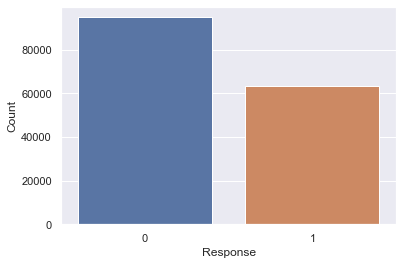

In [458]:
ax = sns.countplot(x = 'y', data = df)
ax.set_xlabel("Response")
ax.set_ylabel("Count")

A review of the response variable indicates that there are are 40.1% positive responses compared to 59.9% negative responses. This means that we might have to consider balancing the classes as we move forward, though initially the class imblance does not seem extreme. 

In [ ]:
p1 = len(df[df["y"]==1])/len(df["y"])*100
p0 = len(df[df["y"]==0])/len(df["y"])*100
print( "y = 0 : ",  len(df[df["y"]==0]), ", %.3f"%p0,"%")
print( "y = 1 : ",  len(df[df["y"]==1]), ", %.3f"%p1,"%")
print("Total Missing Values: ", df.isnull().sum().sum())

y = 0 :  95753 , 59.879 %
y = 1 :  64159 , 40.121 %
Total Missing Values:  1520


In [ ]:
df1 = df.dropna()

The effect of listwise deletion on the response variable balance was examined, but since dropping missing values did not affect the ratio of positive to negative responses we decided that at this point we would not drop records with missing numeric values and consider imputation as a possible option for those variables.    

In [ ]:
p1 = len(df1[df1["y"]==1])/len(df1["y"])*100
p0 = len(df1[df1["y"]==0])/len(df1["y"])*100
print( "y = 0 : ",  len(df1[df1["y"]==0]), ", %.3f"%p0,"%")
print( "y = 1 : ",  len(df1[df1["y"]==1]), ", %.3f"%p1,"%")
print("Total Missing Values: ", df1.isnull().sum().sum()) 

y = 0 :  94846 , 59.881 %
y = 1 :  63546 , 40.119 %
Total Missing Values:  0


#### Categorical Variables

The counts and distribution of each of the categorical variables was examined using a combination of violin plots and bar charts to get a sense for the distribution of occurences among the variables and to determine if any of the categorical variables seem to have a disproportionate effect on the response. Based on the distribution of the response variable as a whole we expected that by class level, there would be an approximate 60/40 split in favor of negative responses. 

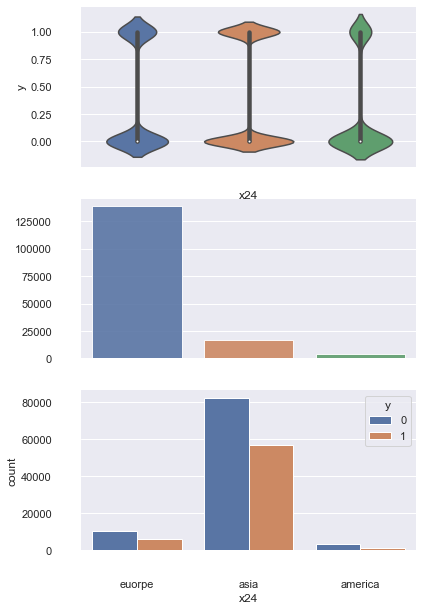

In [301]:
count = df['x24'].value_counts()
f, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
sns.barplot(count.index, count.values, alpha=0.9, ax=axes[1])
sns.violinplot(x='x24', y="y", data=df1, ax=axes[0])
sns.countplot(x = 'x24', data = df, hue = 'y', ax=axes[2])
sns.despine(offset=20, trim=True)

The **x24** variable had three levels. In the violin plots for **x24** we could see a greater occurrence of negative responses compared to that of positive responses. We also saw that the individual observations where not evenly distributed accross the individual levels. We could see that while well over 125,000 overvations had a *euorpe* value, the remaining two levels, *asia* and *america*, combined did not reach 25,000. We did however see the expected distribution of positive and negative responses within the individual levels.    

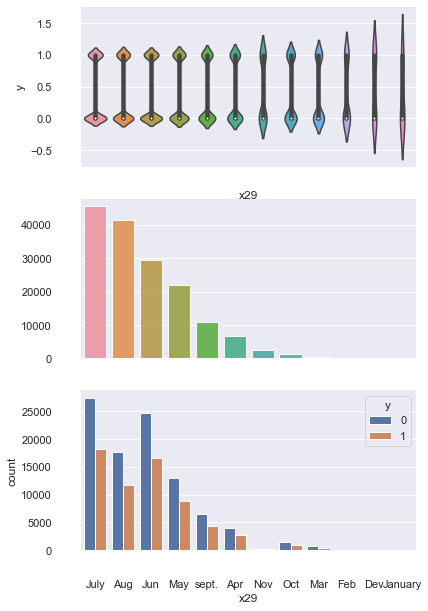

In [302]:
count = df['x29'].value_counts()
f, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
sns.barplot(count.index, count.values, alpha=0.9, ax=axes[1])
sns.violinplot(x="x29", y="y", data=df1, ax=axes[0])
sns.countplot(x = 'x29', data = df, hue = 'y', ax=axes[2])
sns.despine(offset=20, trim=True)

Within our y variable, we cna see that the months where the count is the highest is within the summer months of May - August, which suggests there might be a seasonality.

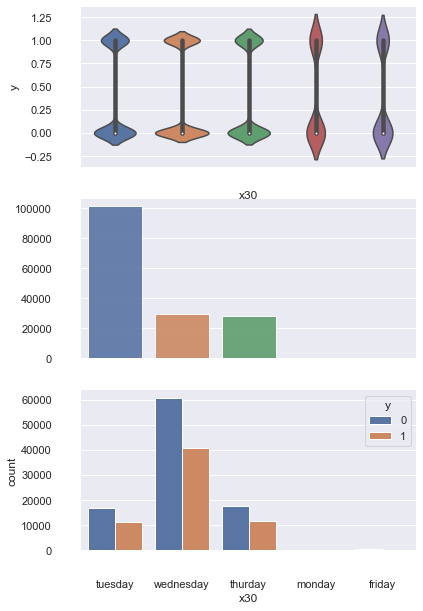

In [303]:
count = df['x30'].value_counts()
f, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
sns.barplot(count.index, count.values, alpha=0.9, ax=axes[1])
sns.violinplot(x="x30", y="y", data=df1, ax=axes[0])
sns.countplot(x = 'x30', data = df, hue = 'y', ax=axes[2])
sns.despine(offset=20, trim=True)

We saw the same accross the same general distributions acrross the 3 variables and found that while the distribution of occurences is not evenly distributed accross the class levels, within the individual levels the distribution of the response is as expected. 

Specifically with the Y variable, Tuesday through Thursday have all the observations with none accounting to Friday - Monday. 

In [466]:
print(count)

wednesday    101492
thurday       29421
tuesday       27947
friday          564
monday          488
Name: x30, dtype: int64


To better visualized the distribution of the response accross the class levels we used stacked bar charts and they seemed to confirm what we observed in the violin and bar charts. This indicates that the categoricalt variables alone may not be strong predictors of the response variable. 

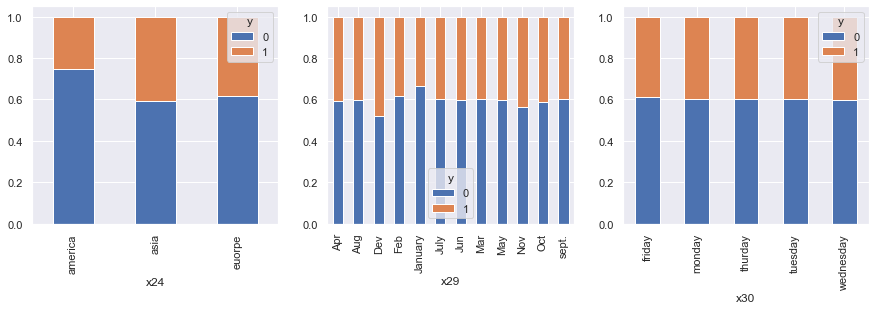

In [314]:
f, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=False)
table1=pd.crosstab(df.x24,df.y)
table2=pd.crosstab(df.x29,df.y)
table3=pd.crosstab(df.x30,df.y)
table1.div(table1.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[0])
table2.div(table2.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[1])
table3.div(table3.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[2])

#### Continous Variables

In [499]:
df_num = df.drop(['x24', 'x29', 'x30'], axis=1)

In [501]:
samp = ["x0","x2","x7","x32","x37","x48","y"]
df_num[samp].describe()

,x0,x2,x7,x32,x37,x48,y
count,158392.000000,158392.000000,158392.000000,158392.000000,158392.000000,158392.000000,158392.000000
mean,-0.000808,-1.148314,-7.697877,-0.000010,0.502723,0.000160,0.401195
std,0.371064,13.274738,30.541562,0.010397,999.670281,1.935087,0.490142
min,-1.592635,-59.394048,-181.506976,-0.050000,-4734.540000,-8.490155,0.000000
25%,-0.251246,-10.166609,-27.315875,-0.010000,-690.690000,-1.320800,0.000000
50%,-0.001818,-1.342199,-6.959275,0.000000,-13.320000,-0.011800,0.000000
75%,0.248622,7.878130,12.215119,0.010000,664.050000,1.318161,1.000000
max,1.600849,63.545653,149.150634,0.050000,5546.990000,8.226552,1.000000


There is much variability between to means, ranges, and standard deviations of the variables. In order to offset the effects of scale between varaibles such as **x32** that ranges from -.05 to .05 and **x37** that ranges from -4734.54 to 5546.99 so form of scaling or standardization will be applied to the numeric variables. As a matter of many of the ranges of the numeric variables seemed more or less symetric with the absolute values of the minimum values being not far off of the absolute values of the maximum values. This was noted in many of the 47 numeric variables. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159912 entries, 0 to 159999
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      159886 non-null  float64
 1   x1      159887 non-null  float64
 2   x2      159874 non-null  float64
 3   x3      159875 non-null  float64
 4   x4      159886 non-null  float64
 5   x5      159875 non-null  float64
 6   x6      159886 non-null  float64
 7   x7      159885 non-null  float64
 8   x8      159891 non-null  float64
 9   x9      159882 non-null  float64
 10  x10     159869 non-null  float64
 11  x11     159882 non-null  float64
 12  x12     159876 non-null  float64
 13  x13     159881 non-null  float64
 14  x14     159878 non-null  float64
 15  x15     159877 non-null  float64
 16  x16     159886 non-null  float64
 17  x17     159885 non-null  float64
 18  x18     159872 non-null  float64
 19  x19     159877 non-null  float64
 20  x20     159874 non-null  float64
 21  x21     15

Looking at the data types of our 49 variables, we can see that most are continuous floats while a few are categorical variables that we may need to create dummy objects to classify. 

In [ ]:
df['x37'] = df['x37'].str.replace(',', '')
df['x37'] = df['x37'].str.replace('$', '')
df['x37'] = df['x37'].astype('float64')

In Order for future analysis, we will need to adjust the dataframe column "x37" by removing the "$"s, ","s and "float64". this will allow us to measure these variables more easily as a classifier. 

In [ ]:
df.loc[df['x30'] =='monday', 'x30'] = 0
df.loc[df['x30'] =='tuesday', 'x30'] = 1
df.loc[df['x30'] =='wednesday', 'x30'] = 2
df.loc[df['x30'] =='thursday', 'x30'] = 3
df.loc[df['x30'] =='thurday', 'x30'] = 3
df.loc[df['x30'] =='friday', 'x30'] = 4
df.loc[df['x30'] =='saturday', 'x30'] = 5
df.loc[df['x30'] =='sunday', 'x30'] = 6
df['x30'] = df['x30'].astype('int32')

Similarly, we will convert our Day of the Week value to numerics which can be interpreted better as categorical variables. The higher number denotes the later in the week, so they can be treated continuously with context. 

In [ ]:
df['x29'].unique()

array(['July', 'Aug', 'Jun', 'May', 'sept.', 'Apr', 'Nov', 'Oct', 'Mar',
       'Feb', 'Dev', 'January'], dtype=object)

In [ ]:
df.loc[df['x29'] =='January', 'x29'] = 1
df.loc[df['x29'] =='Feb', 'x29'] = 2
df.loc[df['x29'] =='Mar', 'x29'] = 3
df.loc[df['x29'] =='Apr', 'x29'] = 4
df.loc[df['x29'] =='May', 'x29'] = 5
df.loc[df['x29'] =='Jun', 'x29'] = 6
df.loc[df['x29'] =='July', 'x29'] = 7
df.loc[df['x29'] =='Aug', 'x29'] = 8
df.loc[df['x29'] =='sept.', 'x29'] = 9
df.loc[df['x29'] =='Oct', 'x29'] = 10
df.loc[df['x29'] =='Nov', 'x29'] = 11
df.loc[df['x29'] =='Dev', 'x29'] = 12
df['x29'] = df['x29'].astype('int32')

Like the days of the week, we will convert the months to numeric values. 

In [ ]:
df['x24'].unique()

array(['euorpe', 'asia', 'america'], dtype=object)

In [5]:
df['x24'] = df['x24'].astype(str)
df.loc[df['x24'] =='euorpe', 'x24'] = 'europe'

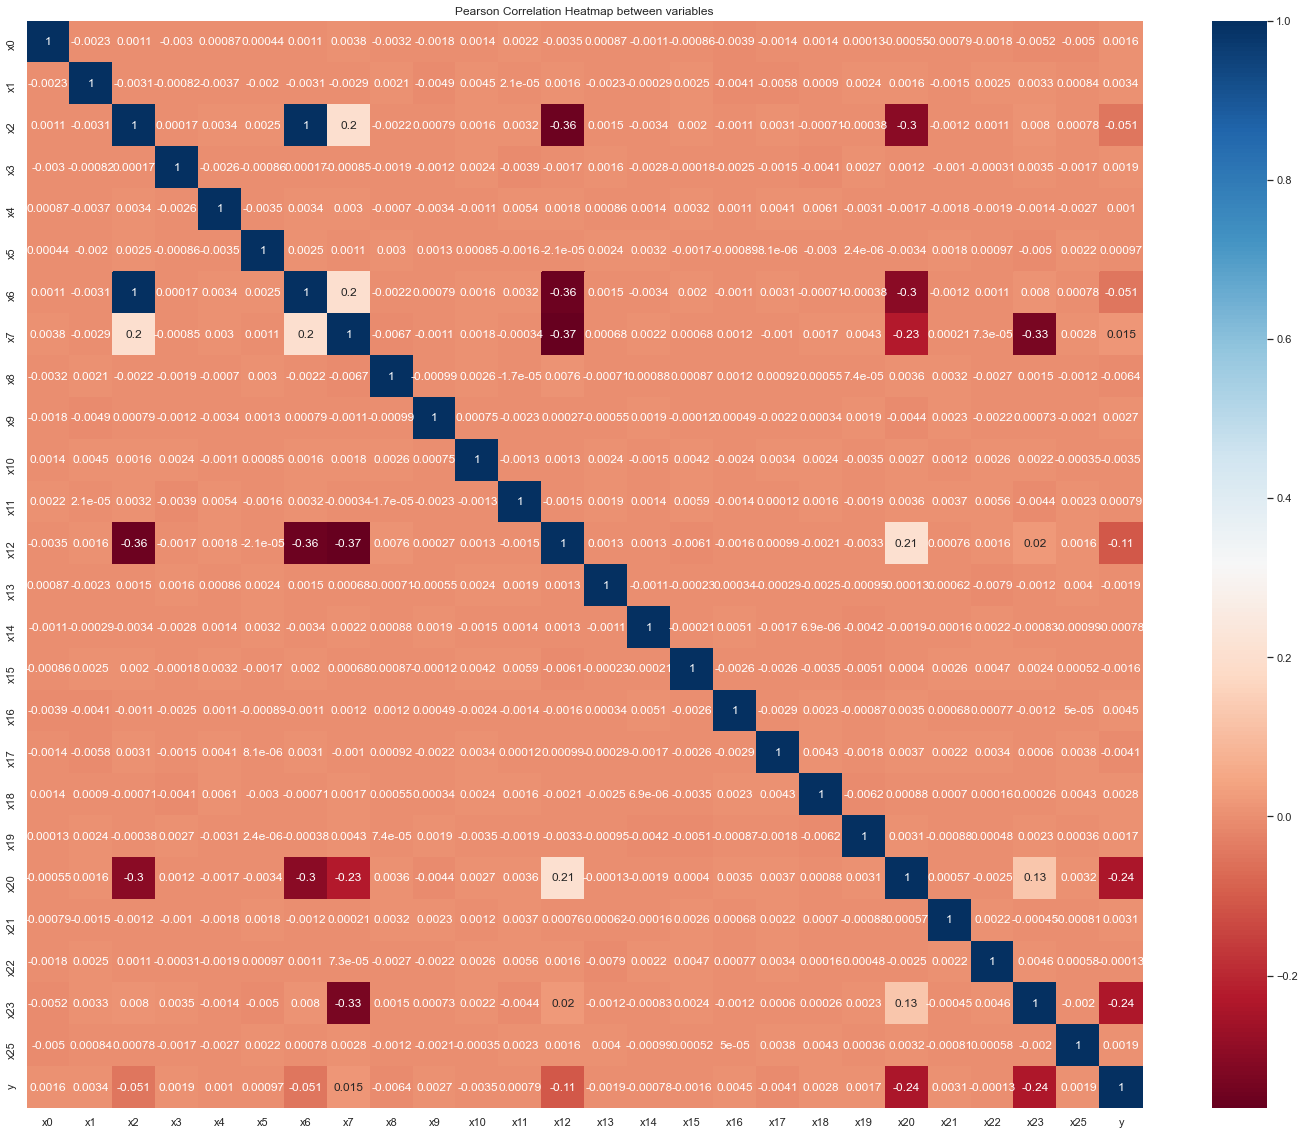

In [523]:
ax, fig = plt.subplots(figsize = (25,20))
sns.set(font_scale=1)
sns.heatmap(dfc1.corr(), annot=True, cmap = 'RdBu') 
plt.title("Pearson Correlation Heatmap between variables")
plt.show()

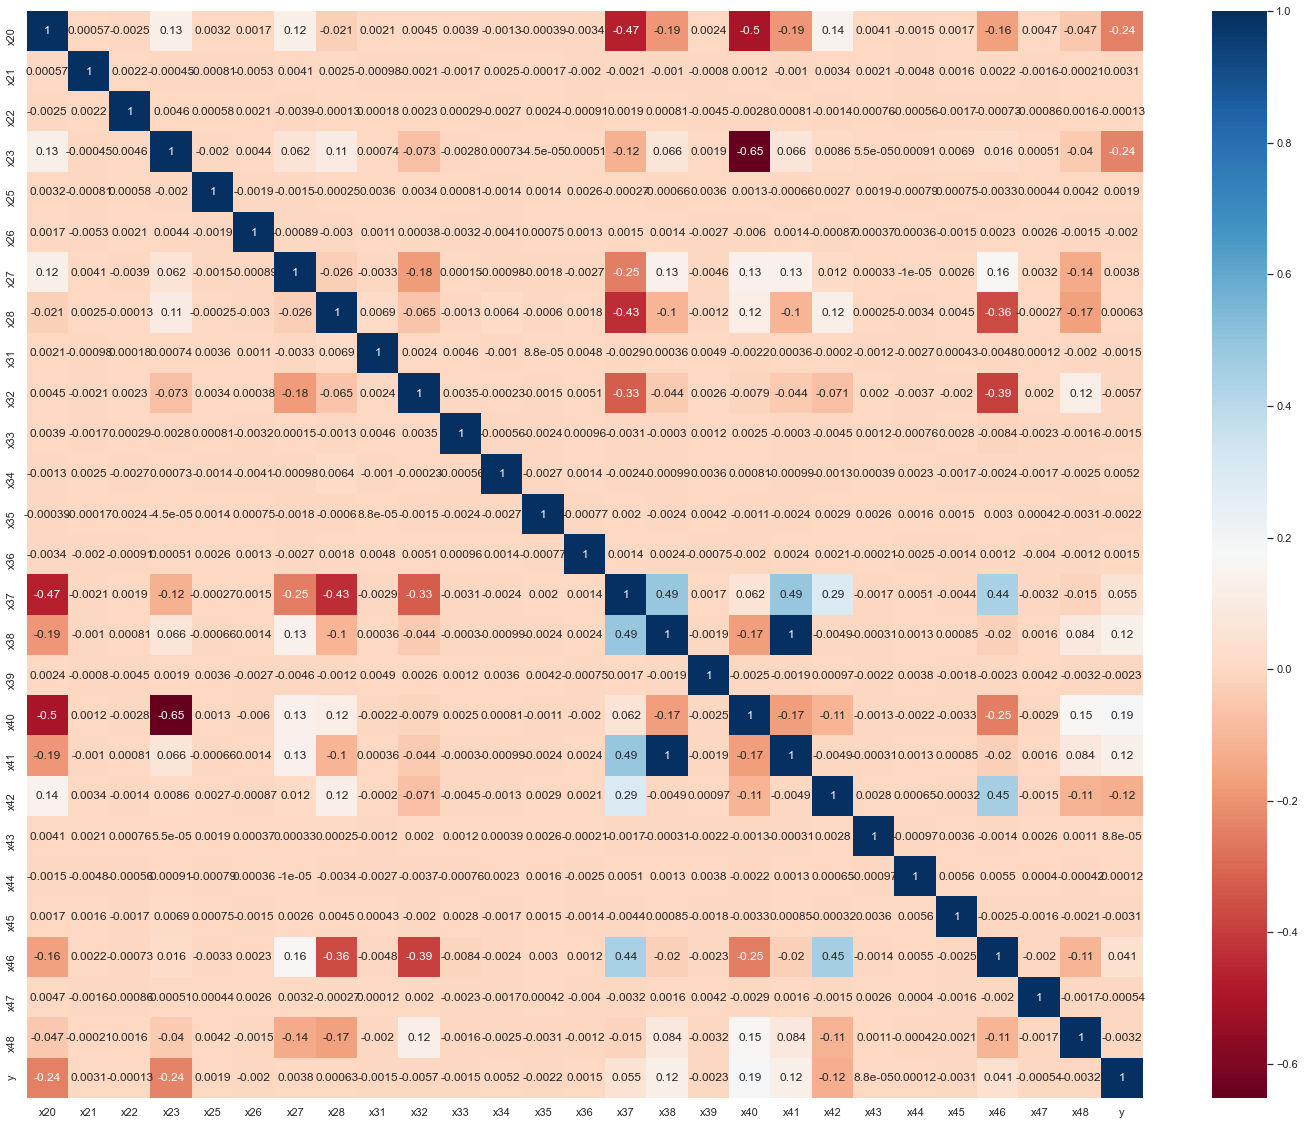

In [525]:
ax, fig = plt.subplots(figsize = (25,20))
sns.heatmap(dfc2.corr(), annot=True, cmap = 'RdBu') 

While no individual variables seemed to indicate a particularly strong correlation with the response we did notice a fair degree of colinearity between the predictive variables. In particular we found a fairly strong negative correlation between **x40** and **x23** and very strong positive correlations between **x6** and **x2** and between **x41** and **x38**. The presence of multicolinearity must be noted as logistic regression methods rely on the assumption that there is no multicolinearity between explanatory variables.

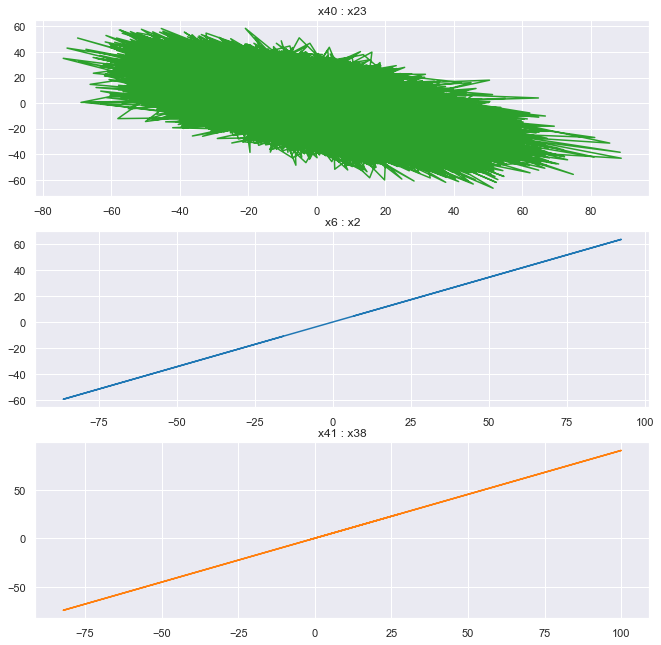

In [549]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize =(11,11))
ax1.set_title("x40 : x23")
ax2.set_title("x6 : x2")
ax3.set_title("x41 : x38")
ax1.plot(df['x40'], df['x23'], 'tab:green')
ax2.plot(df['x6'], df['x2'], 'tab:blue')
ax3.plot(df['x41'], df['x38'], 'tab:orange')

Histograms for each of the numerical variables were reviewed and the visual analysis indicated that for the most part each of the variables has a relatively normal distribution of values. 

In [ ]:
df1 = df_num.iloc[:,0:9]
df2 = df_num.iloc[:,10:19]
df3 = df_num.iloc[:,20:29]
df4 = df_num.iloc[:,30:40]
df5 = df_num.iloc[:,41:47]

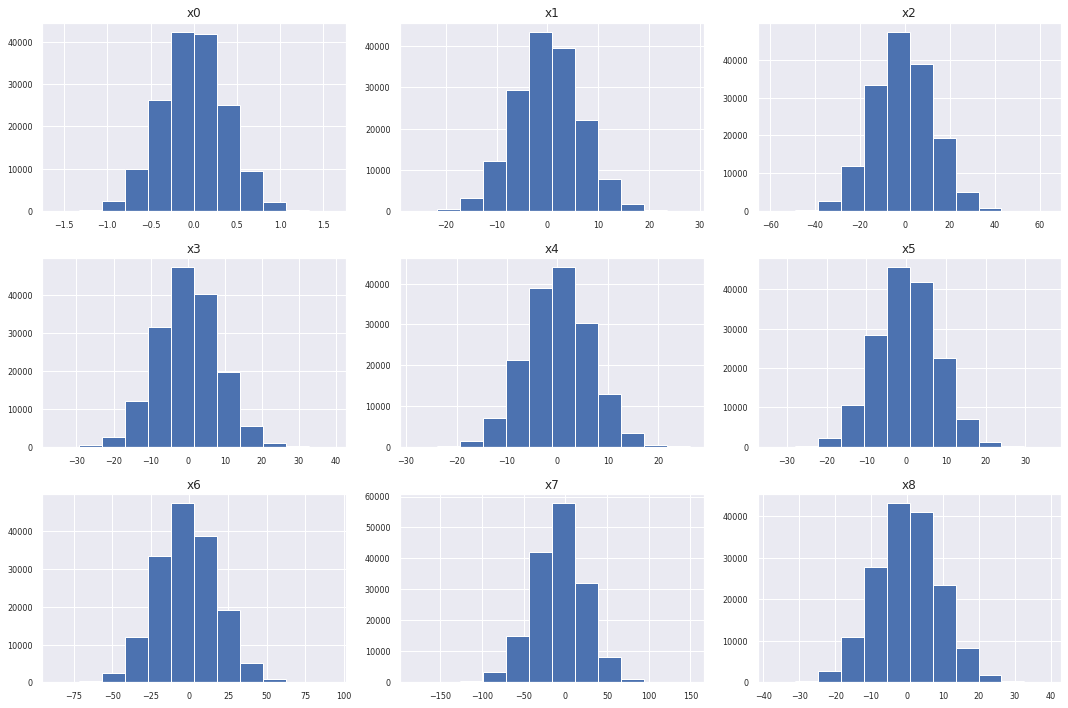

In [ ]:
df1.hist(xlabelsize = 8, ylabelsize = 8, bins = 12, figsize = (15, 10))
plt.tight_layout()
plt.show()

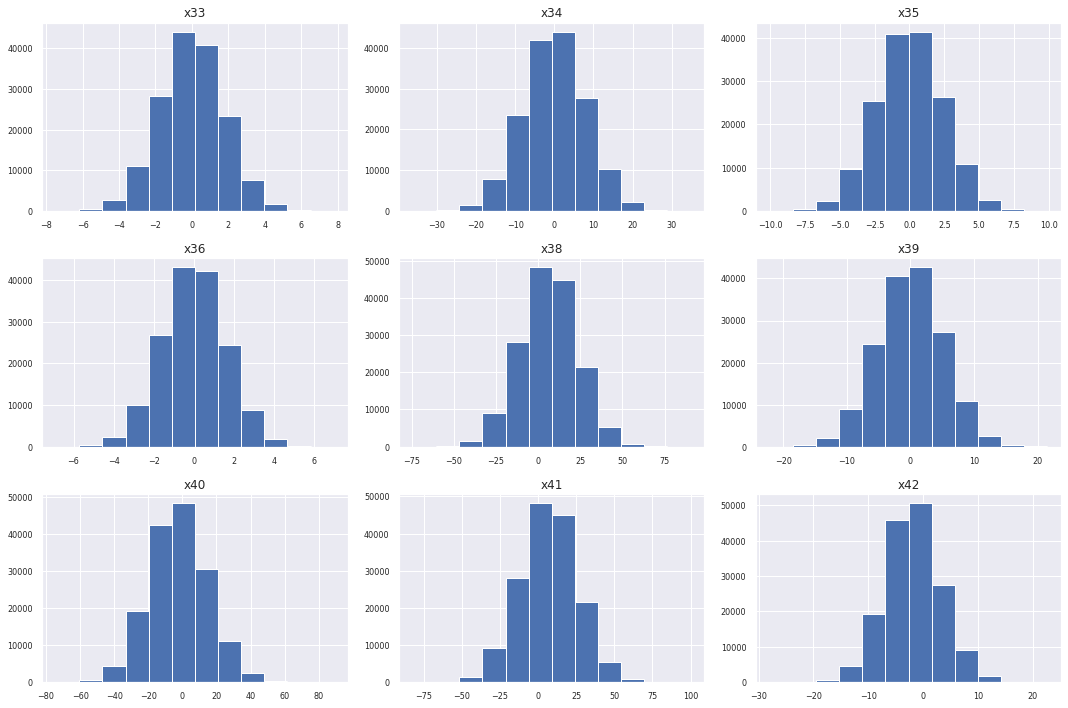

In [ ]:
df4.hist(xlabelsize = 8, ylabelsize = 8, bins = 12, figsize = (15, 10))
plt.tight_layout()
plt.show()

With a little more insight into the data we decided to move on to processing the data for modeling.

# Interim Model Search Data Preparation

Our data preperation process for interim model search consisted of converting the categorical variables into dummy variables, splitting the dataset into train and test sets and finally scaling the values of the variables. 

We then create logistic models and random forest models to better understand feature importance and potential predictive power for the models.

After our interim model search, we performed a final data preperation and splitting of the data which we will explain in its own section below.

#### Create Dummies

In [6]:
df_onehot = df.copy()
df1 = pd.get_dummies(df_onehot, columns=['x24','x29','x30'],prefix = ['','',''])

df1.columns.values

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x25', 'x26', 'x27', 'x28', 'x31',
       'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40',
       'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'y',
       '_america', '_asia', '_europe', '_nan', '_Apr', '_Aug', '_Dev',
       '_Feb', '_January', '_July', '_Jun', '_Mar', '_May', '_Nov',
       '_Oct', '_sept.', '_friday', '_monday', '_thurday', '_tuesday',
       '_wednesday'], dtype=object)

#### Train Test Split

In [601]:
x = df1.loc[:, df1.columns != 'y']
y = df1.loc[:, df1.columns == 'y']

In [602]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1234)

#### Standard Scaling

In [603]:
from sklearn.preprocessing import StandardScaler 

sc_x = StandardScaler() 
x_train = sc_x.fit_transform(x_train) 
x_test = sc_x.transform(x_test)

# Interim Base Model - Logistic Regression

In [618]:
from sklearn.linear_model import LogisticRegression 

lgr = LogisticRegression() 
lgr.fit(x_train, y_train)
y_pred = lgr.predict(x_test) 

In [619]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

cm = confusion_matrix(y_test, y_pred) 

print ("Confusion Matrix : \n", cm, "\n") 
print ("Accuracy  : %.3f" % accuracy_score(y_test, y_pred))
print ("Precision : %.3f" % precision_score(y_test, y_pred))
print ("Recall    : %.3f" % recall_score(y_test, y_pred))

Confusion Matrix : 
 [[19581  4064]
 [ 7708  8245]] 

Accuracy  : 0.703
Precision : 0.670
Recall    : 0.517


In [633]:
cost = 4064*10+7708*500
print("Model Cost: $%.0f" % cost )

Model Cost: $3894640


Our first model run indicates a relatively high cost for the model. Given the constraints that False Positives cost 10 dollars and False Negatives cost 500 dollars, our base case yields a 3.89mm cost.

To attempt to improve this we performed over sampling to attempt to adjust for the imbalance in the dataset. 

#### Over Sampling SMOTE

In [621]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state = 1234)

x_train_os, y_train_os = os.fit_sample(x_train, y_train)

lgros = LogisticRegression()
lgros.fit(x_train_os, y_train_os)
y_pred = lgros.predict(x_test)

In [622]:
cm = confusion_matrix(y_test, y_pred) 

print ("Confusion Matrix : \n", cm, "\n") 
print ("Accuracy  : %.3f" % accuracy_score(y_test, y_pred))
print ("Precision : %.3f" % precision_score(y_test, y_pred))
print ("Recall    : %.3f" % recall_score(y_test, y_pred))

Confusion Matrix : 
 [[17259  6386]
 [ 5139 10814]] 

Accuracy  : 0.709
Precision : 0.629
Recall    : 0.678


In [634]:
cost = 6386*10+5138*500
print("Model Cost: $%.0f" % cost )

Model Cost: $2632860


Over sampling helped improve our overall cost, reducing it by 32.4% to 2.6mm.

# Interim Model Search - Random Forest Testing

Next we turn our attention to testing non-parametric methods to see if we can improve our overall yield.

#### Random Forest Classifier

In [624]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('classifier' , RandomForestClassifier(random_state = 123))])

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm, "\n") 
print ("Accuracy  : %.3f" % accuracy_score(y_test, y_pred))
print ("Precision : %.3f" % precision_score(y_test, y_pred))
print ("Recall    : %.3f" % recall_score(y_test, y_pred))

Confusion Matrix : 
 [[22623  1022]
 [ 2141 13812]] 

Accuracy  : 0.920
Precision : 0.931
Recall    : 0.866


In [635]:
cost = 1022*10+2141*500
print("Model Cost: $%.0f" % cost )

Model Cost: $1080720


A quick random forest model yields a much better overall cost at 1.1mm.

#### Gradient Boosting Classifier

In [637]:
from sklearn.ensemble import GradientBoostingClassifier
gb = Pipeline([('classifier' , GradientBoostingClassifier())])
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm, "\n") 
print ("Accuracy  : %.3f" % accuracy_score(y_test, y_pred))
print ("Precision : %.3f" % precision_score(y_test, y_pred))
print ("Recall    : %.3f" % recall_score(y_test, y_pred))

Confusion Matrix : 
 [[21248  2397]
 [ 4064 11889]] 

Accuracy  : 0.837
Precision : 0.832
Recall    : 0.745


In [636]:
cost = 2397*10+4064*500
print("Model Cost: $%.0f" % cost )

Model Cost: $2055970


Gradient Boosting performs worse at 2mm on the base case.

Given these quick results we perform a random grid search for RandomForest hyperparameters and optimize the model.

# RandomForest RandomSearchCV

For cleanliness we reprep the data. 

We also perform a few other important steps here. 

1) We split the data in order to generate a hold out set. This set will be held back as unseen so that we can test the model against a realistic dataset. 30% of the data will be reserved as a hold out set.

2) We then take the other 70% of the data and split it to a 70/30 dataset for train and test respectively. 

3) We perform iterative imputation on the train and test datasets seperately to avoid any data leakage between the two.

4) We also stratify the split along y as a target variable to ensure balancing between the datasets.



In [89]:
%matplotlib inline

import numpy as np
import pandas as pd
#import modin.pandas as pd
import matplotlib.pyplot as plt

#import cufflinks as cf
#cf.go_offline()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()

from pathos.multiprocessing import ProcessingPool as Pool
import multiprocessing as mp

In [90]:
df = pd.read_csv ('/Volumes/CCV_SSD_1/final_project.csv')

In [91]:
cat = ["x24","x29","x30","x32"]
print(df[cat].describe(), "\n")

df["x32"] = df["x32"].str.rstrip('%')
df["x32"] = df["x32"].apply(pd.to_numeric, errors='coerce').astype('float64')

print("Total Missing Values: ", df.isnull().sum().sum()) 

           x24     x29        x30     x32
count   159972  159970     159970  159969
unique       3      12          5      12
top       asia    July  wednesday   0.01%
freq    138965   45569     101535   40767 

Total Missing Values:  1608


In [92]:
df = df.dropna(subset=['x24', 'x29','x30'])
print("Total Missing Values: ", df.isnull().sum().sum()) 

Total Missing Values:  1520


# DataClean

In [93]:
df['x37'] = df['x37'].str.replace(',', '')
df['x37'] = df['x37'].str.replace('$', '')
df['x37'] = df['x37'].astype('float64')

In [95]:
df.loc[df['x30'] =='monday', 'x30'] = 0
df.loc[df['x30'] =='tuesday', 'x30'] = 1
df.loc[df['x30'] =='wednesday', 'x30'] = 2
df.loc[df['x30'] =='thursday', 'x30'] = 3
df.loc[df['x30'] =='thurday', 'x30'] = 3
df.loc[df['x30'] =='friday', 'x30'] = 4
df.loc[df['x30'] =='saturday', 'x30'] = 5
df.loc[df['x30'] =='sunday', 'x30'] = 6
df['x30'] = df['x30'].astype('int32')

In [96]:
df['x29'].unique()

array(['July', 'Aug', 'Jun', 'May', 'sept.', 'Apr', 'Nov', 'Oct', 'Mar',
       'Feb', 'Dev', 'January'], dtype=object)

In [97]:
df.loc[df['x29'] =='January', 'x29'] = 1
df.loc[df['x29'] =='Feb', 'x29'] = 2
df.loc[df['x29'] =='Mar', 'x29'] = 3
df.loc[df['x29'] =='Apr', 'x29'] = 4
df.loc[df['x29'] =='May', 'x29'] = 5
df.loc[df['x29'] =='Jun', 'x29'] = 6
df.loc[df['x29'] =='July', 'x29'] = 7
df.loc[df['x29'] =='Aug', 'x29'] = 8
df.loc[df['x29'] =='sept.', 'x29'] = 9
df.loc[df['x29'] =='Oct', 'x29'] = 10
df.loc[df['x29'] =='Nov', 'x29'] = 11
df.loc[df['x29'] =='Dev', 'x29'] = 12
df['x29'] = df['x29'].astype('int32')

In [98]:
df['x24'].unique()

array(['euorpe', 'asia', 'america'], dtype=object)

In [106]:
df['x24'] = df['x24'].astype(str)
df.loc[df['x24'] =='euorpe', 'x24'] = 'europe'

In [137]:
#We will split the data to create a holdout dataset.

#Using an Iterative transformer here to fill in NANs
#Also stratifying the data along y

#create a holdout set
from sklearn.model_selection import train_test_split
df_x, unseen_x_test, df_y, unseen_y_test = train_test_split(df.loc[:, df.columns != 'y'], df['y'], test_size=0.30, stratify=df['y'],random_state=42)

In [138]:
print(unseen_x_test.shape)
print(unseen_y_test.shape)

df_x.reset_index(drop=True, inplace=True)
unseen_x_test.reset_index(drop=True, inplace=True)
df_y.reset_index(drop=True, inplace=True)
unseen_y_test.reset_index(drop=True, inplace=True)

(47974, 50)
(47974,)


In [140]:
##IMPUTE TRAIN
#scale the test data seperately from the unseen holdout set
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

x = df_x.loc[:, df_x.dtypes == 'float64'].values #returns a numpy array
x = imp.fit_transform(x)
x = pd.DataFrame(x)
x.columns = df_x.loc[:, df_x.dtypes == 'float64'].columns
unscaled = pd.concat([pd.DataFrame(x),df_x['x29'], df_x['x30'],pd.get_dummies(df_x['x24']), df_y], axis=1)

##IMPUTE HOLDOUT
#scale the test data seperately from the unseen holdout set
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

x = unseen_x_test.loc[:, unseen_x_test.dtypes == 'float64'].values #returns a numpy array
x = imp.fit_transform(x)
x = pd.DataFrame(x)
x.columns = unseen_x_test.loc[:, unseen_x_test.dtypes == 'float64'].columns
x = pd.DataFrame(x)
one_hot = pd.get_dummies(unseen_x_test.x24)
unseen_x = pd.concat([x,unseen_x_test['x29'], unseen_x_test['x30'],one_hot], axis=1)

In [141]:
print(unscaled.shape)
print(unseen_x.shape)
print(unseen_y.shape)

(111938, 53)
(47974, 52)
(47974,)


## RandomForest Random Gridsearch

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
X_train, X_test, y_train, y_test = train_test_split(unscaled.loc[:, unscaled.columns != 'y'], unscaled['y'], test_size=0.30, random_state=42)

#set cores
n_jobs = 16
rf = RandomForestClassifier(n_jobs=n_jobs, random_state=1)



# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_gs = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = n_jobs)

rf_gs.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  7.9min
/opt/tljh/user/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed: 72.7min
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed: 157.4min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=16, random_state=1),
                   n_iter=100, n_jobs=16,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [144]:
rf_best = rf_gs.best_estimator_
print(rf_gs.best_params_)

{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}


In [1]:
#Best Parameters
#{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}

In [145]:
# predictions
rf_predict = rf_best.predict(X_test)

In [161]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rf_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rf_predict))
print('\n')

=== Confusion Matrix ===
[[19162   924]
 [ 1562 11934]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     20086
           1       0.93      0.88      0.91     13496

    accuracy                           0.93     33582
   macro avg       0.93      0.92      0.92     33582
weighted avg       0.93      0.93      0.93     33582





In [162]:
print ("Confusion Matrix : \n", confusion_matrix, "\n") 
print ("Accuracy  : %.3f" % accuracy_score(y_test, rf_predict))
print ("Precision : %.3f" % precision_score(y_test, rf_predict))
print ("Recall    : %.3f" % recall_score(y_test, rf_predict))

Confusion Matrix : 
 <function confusion_matrix at 0x7f77a91f07b8> 

Accuracy  : 0.926
Precision : 0.928
Recall    : 0.884


In [163]:
cost = 924*10+1562*500
print("Model Cost: $%.0f" % cost )

Model Cost: $790240


In [151]:
#AUC Cross Validation on Test
rf_cv_score = cross_val_score(rf_best, X_test, y_test, cv = 5, scoring='roc_auc')

In [152]:
rf_cv_score.mean()

0.9673367692081143

In [153]:
#AUC Cross Validation on Unseen Data
rf_cv_score = cross_val_score(rf_best, unseen_x, unseen_y, cv = 5, scoring='roc_auc')

In [154]:
rf_cv_score.mean()

0.9725951528103151

While our model performed well comparative to other models, we still yield an overall cost of $790k. To gain visibility into a realistic cost range, we also predict on unseen data (hold out) and can thus calculate a range of potential cost.

# RandomForest Performance on Unseen Data - Realistic Performance Cost

In [169]:
#Lets take a look at unseen data prediction
# predictions
rf_predict = rf_best.predict(unseen_x)

In [171]:
print("=== Confusion Matrix ===")
print(confusion_matrix(unseen_y, rf_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(unseen_y, rf_predict))
print('\n')

=== Confusion Matrix ===
[[27472  1254]
 [ 2189 17059]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     28726
           1       0.93      0.89      0.91     19248

    accuracy                           0.93     47974
   macro avg       0.93      0.92      0.92     47974
weighted avg       0.93      0.93      0.93     47974





In [172]:
print ("Confusion Matrix : \n", confusion_matrix, "\n") 
print ("Accuracy  : %.3f" % accuracy_score(unseen_y, rf_predict))
print ("Precision : %.3f" % precision_score(unseen_y, rf_predict))
print ("Recall    : %.3f" % recall_score(unseen_y, rf_predict))

Confusion Matrix : 
 <function confusion_matrix at 0x7f77a91f07b8> 

Accuracy  : 0.928
Precision : 0.932
Recall    : 0.886


In [174]:
cost = 1254*10+2189*500
print("Model Cost: $%.0f" % cost )

Model Cost: $1107040


It is safe to assume that the cost of this model is within the range of 790k - 1.1mm dollars.

# Overall Feature Importance

While we have this model we can now take the opportunity to review feature importance. 

Feature ranking:
1. feature 23 (0.073907)
2. feature 20 (0.063212)
3. feature 45 (0.060725)
4. feature 46 (0.058740)
5. feature 39 (0.050666)
6. feature 12 (0.048658)
7. feature 27 (0.047252)
8. feature 26 (0.046068)
9. feature 37 (0.044402)
10. feature 34 (0.043319)
11. feature 7 (0.039844)
12. feature 43 (0.035534)
13. feature 38 (0.034696)
14. feature 35 (0.034420)
15. feature 6 (0.028961)
16. feature 2 (0.028662)
17. feature 29 (0.026686)
18. feature 15 (0.007506)
19. feature 3 (0.007495)
20. feature 21 (0.007461)
21. feature 14 (0.007452)
22. feature 5 (0.007435)
23. feature 22 (0.007432)
24. feature 8 (0.007427)
25. feature 0 (0.007409)
26. feature 28 (0.007389)
27. feature 18 (0.007385)
28. feature 9 (0.007385)
29. feature 10 (0.007384)
30. feature 41 (0.007374)
31. feature 32 (0.007371)
32. feature 17 (0.007370)
33. feature 36 (0.007357)
34. feature 30 (0.007353)
35. feature 42 (0.007349)
36. feature 33 (0.007345)
37. feature 40 (0.007341)
38. feature 4 (0.007338)
39. feature 3

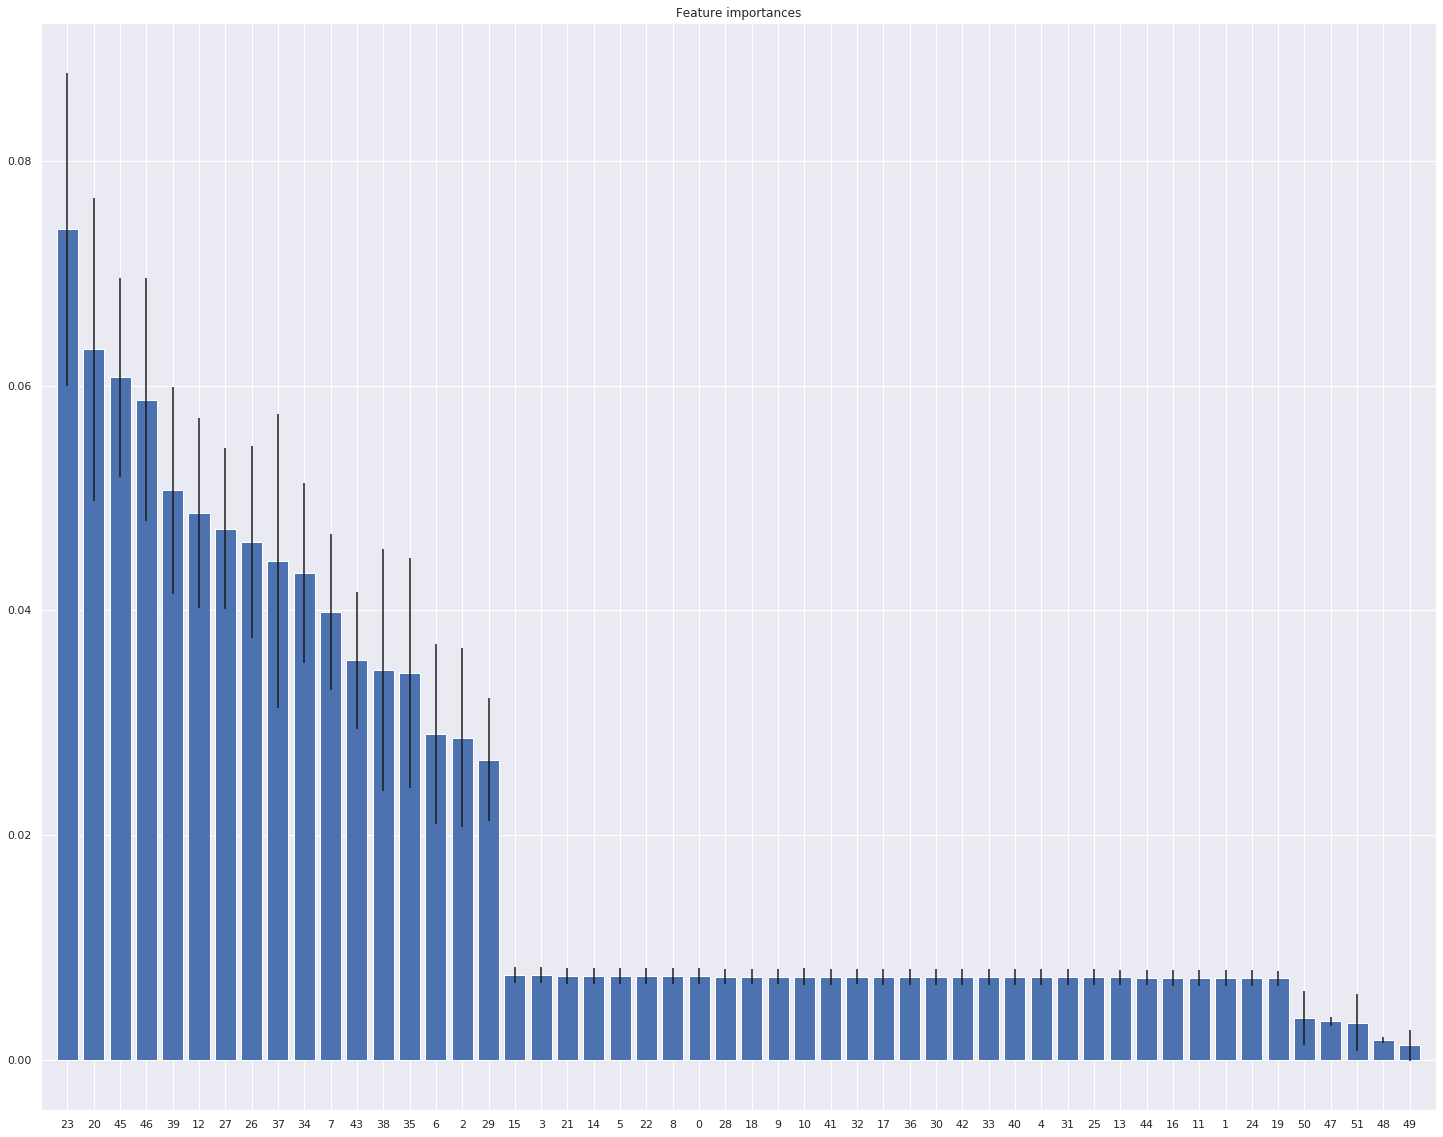

In [158]:
# Feature Importance
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

We see here that while we dont fully understand what this data is, it is clear that features **23, 20, 45, 46, 39, 12, 27, 26, 37, 34, 7, 43, 38, 35, 6, 2, and 29** are the most influential parameters in this model, with **23** being the most influential.

If we were creating a final model that needed interpretation and explanability it would be important to review whether some of these variables should be dropped. 

# Final Model Generation

For our final model search and generation we leveraged pycaret to narrow down potential model options and create a succint optimization.

We will recreate our datasets to start clean.

In [ ]:
##TRAIN
#scale the test data seperately from the unseen holdout set
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

x = df_x.loc[:, df_x.dtypes == 'float64'].values #returns a numpy array
x = imp.fit_transform(x)
x = pd.DataFrame(x)
x.columns = df_x.loc[:, df_x.dtypes == 'float64'].columns
unscaled = pd.concat([pd.DataFrame(x),df_x['x29'], df_x['x30'],pd.get_dummies(df_x['x24']), df_y], axis=1)

##HOLDOUT
#scale the test data seperately from the unseen holdout set
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

x = unseen_x_test.loc[:, unseen_x_test.dtypes == 'float64'].values #returns a numpy array
x = imp.fit_transform(x)
x = pd.DataFrame(x)
x.columns = unseen_x_test.loc[:, unseen_x_test.dtypes == 'float64'].columns
x = pd.DataFrame(x)
one_hot = pd.get_dummies(unseen_x_test.x24)
unseen_x = pd.concat([x,unseen_x_test['x29'], unseen_x_test['x30'],one_hot], axis=1)

In [ ]:
unscaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111938 entries, 0 to 111937
Data columns (total 53 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   x0       111938 non-null  float64
 1   x1       111938 non-null  float64
 2   x2       111938 non-null  float64
 3   x3       111938 non-null  float64
 4   x4       111938 non-null  float64
 5   x5       111938 non-null  float64
 6   x6       111938 non-null  float64
 7   x7       111938 non-null  float64
 8   x8       111938 non-null  float64
 9   x9       111938 non-null  float64
 10  x10      111938 non-null  float64
 11  x11      111938 non-null  float64
 12  x12      111938 non-null  float64
 13  x13      111938 non-null  float64
 14  x14      111938 non-null  float64
 15  x15      111938 non-null  float64
 16  x16      111938 non-null  float64
 17  x17      111938 non-null  float64
 18  x18      111938 non-null  float64
 19  x19      111938 non-null  float64
 20  x20      111938 non-null  

Now that we applied our cleaning data to our x data frame, we see that we have nearly 112k observations with 46 floats and 4 int variables, what we addressed previously. 

In [ ]:
from pycaret.classification import *
#intialize the setup

exp_clf = setup(unscaled
                ,target = 'y'
                ,train_size = 0.7
                ,profile = False
                ,remove_multicollinearity = True
                ,polynomial_features = False
                ,feature_interaction = True
                ,feature_ratio = False
                ,feature_selection = True
                ,fix_imbalance = True
                ,silent=True
                #,cluster = True
                ,pca = False
                ,numeric_imputation = 'mean'
                ,normalize=True
                ,categorical_features = ['x29','x30','america','asia','europe']
                ,n_jobs=32
               )

Setup Succesfully Completed!


,Description,Value
0,session_id,1174
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(111938, 53)"
4,Missing Values,False
5,Numeric Features,47
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Next, we will use pycaret that will allow us to test different modeling methods to see which one drives the most efficient accuracy, AUC, recall, Precision, F1 score, Kappa and MCC. Since false negatives are most impactful to the cost of our model, which means we need to ensure our recall is optimized and prioritized over precision. 

Our setup includes making sure the following:
* We will remove multicollinearity
* We will assume that there may be feature interactions
* We will over sample to adjust for class imbalance
* We will normalize the dataset
* To minimize training time we will use sampling, which is default
* And we assume that x29, x30, and all one-hot variables are categorical

In [ ]:
# compare all baseline models and select top 5
top5 = compare_models(n_select = 5) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.9372,0.9814,0.9193,0.9237,0.9215,0.8691,0.8691,31.2079
1,Extra Trees Classifier,0.9318,0.9788,0.9093,0.9198,0.9145,0.8578,0.8578,2.6477
2,Light Gradient Boosting Machine,0.9169,0.9722,0.8993,0.8942,0.8967,0.8272,0.8272,2.1071
3,Random Forest Classifier,0.9100,0.9630,0.8666,0.9051,0.8854,0.8114,0.8120,1.4597
4,K Neighbors Classifier,0.8783,0.9545,0.9576,0.7859,0.8633,0.7555,0.7675,2.5836
5,Gradient Boosting Classifier,0.8721,0.9432,0.8618,0.8267,0.8439,0.7356,0.7361,433.4065
6,Extreme Gradient Boosting,0.8700,0.9422,0.8630,0.8220,0.8420,0.7317,0.7324,7.6006
7,Logistic Regression,0.8619,0.9331,0.8624,0.8067,0.8336,0.7158,0.7169,4.7835
8,SVM - Linear Kernel,0.8535,0.0000,0.8578,0.7939,0.8245,0.6991,0.7008,2.0954
9,Linear Discriminant Analysis,0.8488,0.9242,0.8590,0.7846,0.8201,0.6901,0.6922,2.4622


Running a comparision of all our baseline models we can see that catboost was our best performing with regard to Accuracy, AUC, Precision and F1 score. 

We will create a catboost model to optimize.

In [ ]:
catboost = create_model(estimator = 'catboost', ensemble = True, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9387,0.9812,0.9297,0.9186,0.9241,0.8728,0.8728
1,0.9363,0.9803,0.9179,0.9229,0.9204,0.8673,0.8674
2,0.9334,0.9794,0.9198,0.9146,0.9172,0.8615,0.8615
3,0.9379,0.9808,0.9173,0.9270,0.9221,0.8704,0.8705
4,0.9363,0.9804,0.9195,0.9216,0.9206,0.8674,0.8674
5,0.9326,0.9812,0.9087,0.9222,0.9154,0.8594,0.8595
6,0.9375,0.9820,0.9217,0.9223,0.9220,0.8698,0.8698
7,0.9345,0.9791,0.9131,0.9228,0.9180,0.8635,0.8635
8,0.9400,0.9815,0.9198,0.9299,0.9248,0.8749,0.8750
9,0.9338,0.9808,0.9144,0.9200,0.9172,0.8620,0.8620


To explore ways to optimize our catboost model we will perform a bagging procedure (similar to boostrap aggregating) which will take an ensemble of 10 differently sampled observations from the training set and average the results across all 10. This ensures that our catboost is not overfit to a training set and ensure's it's generalizable across all the training data. 

In [ ]:
# select best model 
best = automl(optimize = 'MCC')

Finally we utilize automl to return the best model generated in the current session, based on the Matthews Correlation Coefficient (MCC). We leverage MCC over F1 or other metrics since it is resilient against class imbalance. 

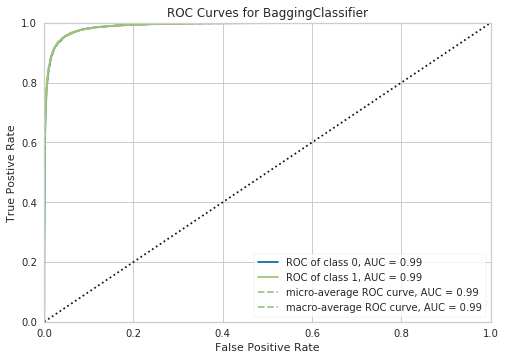

In [ ]:
plot_model(best)

Optimizing our MCC score through AutoML, we generated the ROC curve above which had a peak AUC of 0.99 for both class 0 and class 1 in our testing y value. 

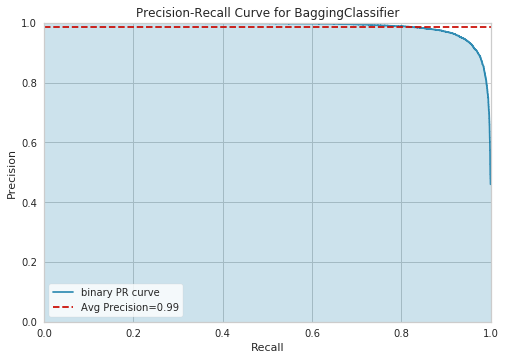

In [ ]:
plot_model(best, plot='pr')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


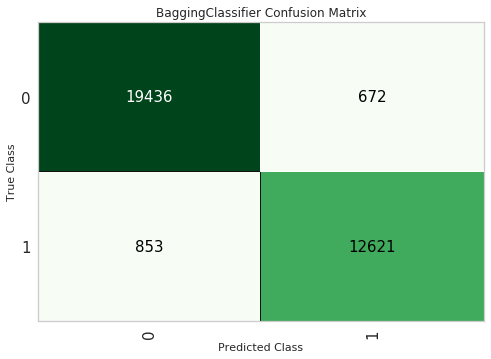

In [ ]:
plot_model(best, plot='confusion_matrix')

Here is our confusion matrix on our testing set using our best performing model. In it we can see that generally we have 1,500 misclassified observations out of nearly 34,000 sampled observations. 

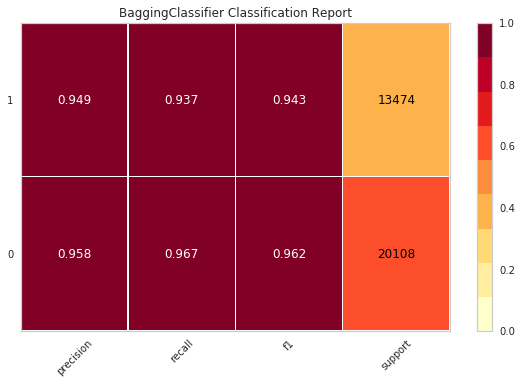

In [ ]:
plot_model(best, plot='class_report')

As mentioned before, the cost of missing on recall is more dire than precision, and here we can see that our classifier is in the mid 90% for both groups. 

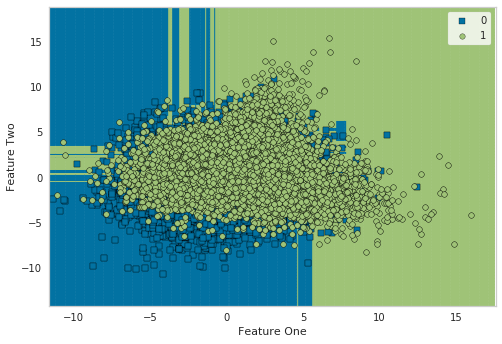

In [ ]:
plot_model(best, plot='boundary')

The plot above shows the boundaries for decisioning between observations classified as 0 and 1 in our model. 

In [ ]:
plot_model(best, plot='parameter')

,Parameters
base_estimator__thread_count,32
base_estimator__silent,True
base_estimator__random_state,1174
base_estimator,<catboost.core.CatBoostClassifier object at 0x...
bootstrap,True
bootstrap_features,False
max_features,1
max_samples,1
n_estimators,10
n_jobs,32


Looking further in our catboost tuning parameters that drove our model performance, the output is above. As you can see we employed bootstrapping on 10 estimators with no warm start. 

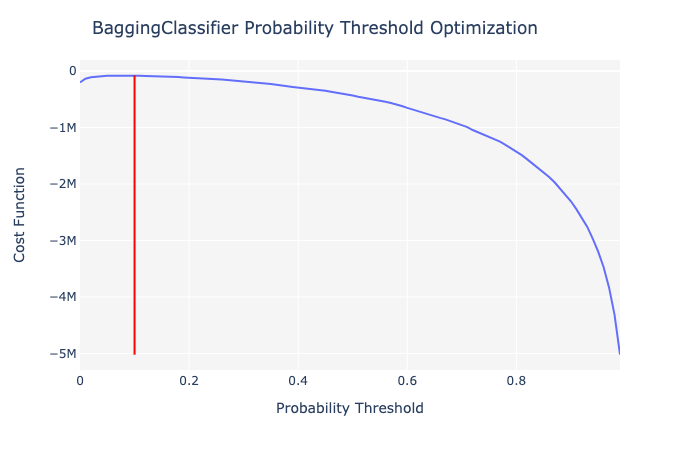

Optimized Probability Threshold: 0.1 | Optimized Cost Function: -79700


In [ ]:
# optimize threshold for trained model
optimize_threshold(best, false_positive = -10, false_negative = -500)

Finally we can optimize our model usage by setting the probability threshold explicitly. Here we use our cost metrics for false positives and false negatives to locate the optimal threshold visually. 

We see that the optimal is 0.1 and can now predict on our unseen holdout set.

In [ ]:
predictions = predict_model(best, probability_threshold=0.1, data=unseen_x)

Using our best parameters, we will move forward with predicting our final confusion matrix which will inform our cost out method. 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Here, we can see that our best model gave us a precision misclassification count 6,899 and a recall misclassification count of 209. While our precision is lower, it is ultimately less costly than the recall. Our aim is to ensure the misclassifications of false positives is not 50x more than the true negatives. 

In [ ]:
print ("Confusion Matrix : \n", confusion_matrix(unseen_y_test, predictions['Label']), "\n") 
print ("Accuracy  : %.3f" % accuracy_score(unseen_y_test, predictions['Label']))
print ("Precision : %.3f" % precision_score(unseen_y_test, predictions['Label']))
print ("Recall    : %.3f" % recall_score(unseen_y_test, predictions['Label']))

Confusion Matrix : 
 [[21827  6899]
 [  209 19039]] 

Accuracy  : 0.852
Precision : 0.734
Recall    : 0.989


Here's the calculation of accuracy, precision and recall which shows that we emphasized recall mostly over precision in our tuning parameters.

In [ ]:
cost = 6899*10+209*500
print("Model Cost: $%.0f" % cost )

Model Cost: $173490


Calculating every missed true negative x 500 dollars and every false positive by 10 dollars, across all our observations, we generated a total model cost of 173,490 dollars.

## Cost Per Unit Classified

Our final per unit classified cost turns out to be as follows:

In [ ]:
print("Model Unit Cost: $%.2f" % (cost / unseen_y_test.shape[0]) ) 

Model Unit Cost: $3.62


# Conclusion

We can now calculate a full compartive review of what each model would potentially cost. The unit cost for each predicted category shows a clear winner in our optimized Catboost model, and the fact that it was validated against completely unseen data gives us high confidence for the future deployment.

| Model                                        | Overall Cost | Unit Cost |
|----------------------------------------------|--------------|-----------|
| Logistic (base)                              | \$3,894,640   | \$98.35    |
| Logistic (over sampling)                     | \$2,632,860   | \$66.49    |
| RandomForest                                 | \$1,080,720   | \$27.29    |
| Gradient Boosting                            | \$2,055,970   | \$51.92    |
| RandomForest (Random Search)                 | \$790,240     | \$23.53    |
| RandomForest (Random Search) - Unseen   Data | \$1,107,040   | \$23.08    |
| Catboost                                     | \$433,220     | \$12.90    |
| **Catboost (optimized)**                         | **\$173,490**     | **\$3.62**     |

We can also reiterate the importance of the following features:
**23, 20, 45, 46, 39, 12, 27, 26, 37, 34, 7, 43, 38, 35, 6, 2, and 29** are the most influential parameters in this model, with **23** being the most influential.

Feature ranking with weight:
1. feature 23 (0.073907)
2. feature 20 (0.063212)
3. feature 45 (0.060725)
4. feature 46 (0.058740)
5. feature 39 (0.050666)
6. feature 12 (0.048658)
7. feature 27 (0.047252)
8. feature 26 (0.046068)
9. feature 37 (0.044402)
10. feature 34 (0.043319)
11. feature 7 (0.039844)
12. feature 43 (0.035534)
13. feature 38 (0.034696)
14. feature 35 (0.034420)
15. feature 6 (0.028961)
16. feature 2 (0.028662)
17. feature 29 (0.026686)